In [44]:
import pandas as pd


from prophet.diagnostics import cross_validation, performance_metrics

import matplotlib.pyplot as plt

import seaborn as sb
import numpy as np
from prophet import Prophet
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys 

from tensorflow.keras import Sequential

# from keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense, LSTM, Dropout  # ,CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

sys.path.append("C:\\Users\\LENOVO\\PycharmProjects\\TimeSeriesLabs")
from toolbox import *


def forecast(y, T, h):
    T = T - 1
    y_hat = []
    for i in range(1, h + 1):
        if i == 1:
            y_hat.append(0.7428 * y[T] + 0.0568 * y[T - 4] + 0.0428 * y[T - 6])
        elif i == 2:
            y_hat.append(0.7428 * y_hat[0] + 0.0568 * y[T - 3] + 0.0428 * y[T - 5])
        elif i == 3:
            y_hat.append(0.7428 * y_hat[1] + 0.0568 * y[T - 2] + 0.0428 * y[T - 4])
        elif i == 4:
            y_hat.append(0.7428 * y_hat[2] + 0.0568 * y[T - 1] + 0.0428 * y[T - 3])
        elif i == 5:
            y_hat.append(0.7428 * y_hat[3] + 0.0568 * y[T] + 0.0428 * y[T - 2])
        elif i == 6:
            y_hat.append(0.7428 * y_hat[4] + 0.0568 * y_hat[0] + 0.0428 * y[T - 1])
        elif i == 7:
            y_hat.append(0.7428 * y_hat[5] + 0.0568 * y_hat[1] + 0.0428 * y[T])
        else:
            y_hat.append(
                0.7428 * y_hat[i - 1 - 1]
                + 0.0568 * y_hat[i - 5 - 1]
                + 0.0428 * y[i - 7 - 1]
            )
    y_hat = np.array(y_hat)
    return y_hat

## 데이터 확인

In [45]:
train_df = pd.read_csv("./open/train.csv")

In [46]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


In [47]:
train_df.tail(5)

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8
23010,2022-12-31,2.1,-5.1,7.2,0.0,65.5,1.4,1.1,4.16,11.5,-1.2


In [48]:
train_df.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

### 일시 데이터 datetime으로 변경

In [49]:
train_df['일시'] = pd.to_datetime(train_df['일시']) 

<Axes: xlabel='강수량', ylabel='평균기온'>

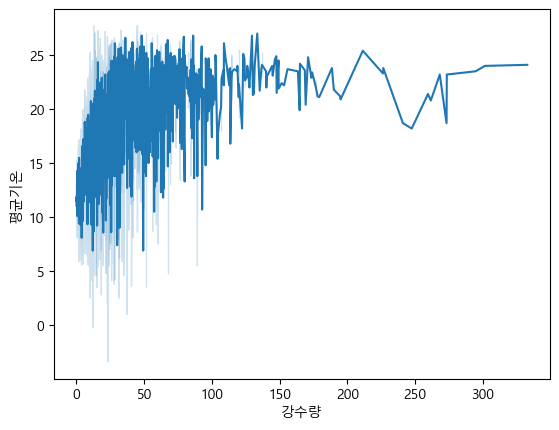

In [50]:
plt.rc("font", family="Malgun Gothic")

sb.lineplot(x="강수량", y="평균기온", data=train_df)

계절 간의 평균 기온차이가 있는 것을 확인가능.

## Prophet을 사용한 예측

-  prophet에서 데이터를 인식하도록 일시는 ds로, target값인 평균기온은 y로 지정해줍니다.


In [51]:
# train_df.rename(columns={'일시':'ds',"평균기온":"y"},inplace=True)

In [52]:
# m = Prophet(changepoint_prior_scale=0.05)
# m.add_seasonality(name="quarterly", period=365.25 / 4, fourier_order=5)
# m.fit(train_df)

In [53]:
len(train_df)

23011

#### 최고기온, 최저기온, 일교차, 강수량, 평균풍속, 일조합, 일사합의 결측치를 처리할 필요가 있다

최고기온, 최저기온, 평균풍속, 일조합, 일사합 결측치는 선형보간으로 대체
보간된 최고기온과 최저기온을 통해 일교차 결측치를 계산


In [54]:
train_df.isnull().sum()     

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

#### 강수량은 결측치가 너무 많기 때문에 삭제한다.

In [55]:
train_df.drop('강수량',axis=1,inplace=True)

In [56]:
null_cols = ["최고기온", "최저기온", "평균풍속", "일조합", "일사합"]
for col in null_cols:
    train_df[col].interpolate(method="linear", inplace=True)

train_df["일교차"] = train_df["최고기온"] - train_df["최저기온"]

In [57]:
train_df.corr()

,일시,최고기온,최저기온,일교차,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,1.000000,0.048833,0.059352,-0.035999,-0.231132,-0.043089,0.033525,0.104051,0.043902,0.056060
최고기온,0.048833,1.000000,0.962798,0.182015,0.306833,-0.227326,0.063823,0.437281,-0.125971,0.989548
최저기온,0.059352,0.962798,1.000000,-0.090465,0.442913,-0.185559,-0.117911,0.278504,-0.297558,0.989342
일교차,-0.035999,0.182015,-0.090465,1.000000,-0.480861,-0.162586,0.664276,0.600261,0.618832,0.046904
평균습도,-0.231132,0.306833,0.442913,-0.480861,1.000000,-0.111971,-0.591219,-0.416768,-0.638990,0.376363
평균풍속,-0.043089,-0.227326,-0.185559,-0.162586,-0.111971,1.000000,0.055022,0.048336,0.058779,-0.209078
일조합,0.033525,0.063823,-0.117911,0.664276,-0.591219,0.055022,1.000000,0.782837,0.958933,-0.031165
일사합,0.104051,0.437281,0.278504,0.600261,-0.416768,0.048336,0.782837,1.000000,0.631977,0.357999
일조율,0.043902,-0.125971,-0.297558,0.618832,-0.638990,0.058779,0.958933,0.631977,1.000000,-0.218212
평균기온,0.056060,0.989548,0.989342,0.046904,0.376363,-0.209078,-0.031165,0.357999,-0.218212,1.000000


In [58]:
train_df.isnull().sum()

일시         0
최고기온       0
최저기온       0
일교차        0
평균습도       0
평균풍속       0
일조합        0
일사합     4749
일조율      366
평균기온       0
dtype: int64

##### 일사합과 일조율은 선형 보간으로 처리가 되지 않아 bfill을 통하여 처리하였다.

In [59]:
train_df["일사합"].fillna(method="bfill", inplace=True)
train_df["일조율"].fillna(method="bfill", inplace=True)

<Axes: >

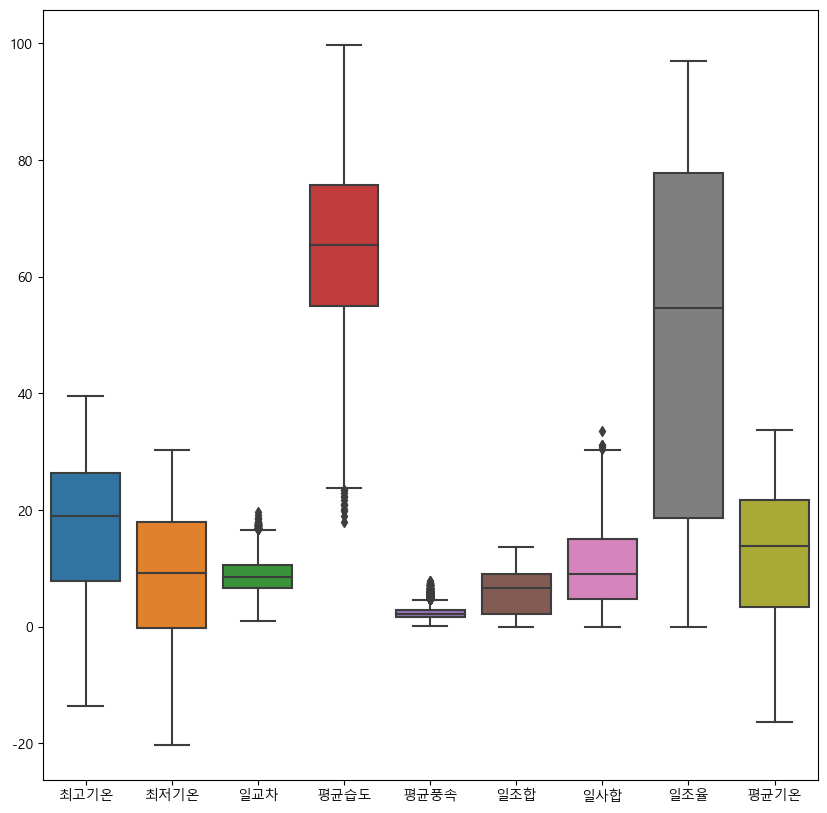

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
sb.boxplot(train_df)

### 계절 변수 생성

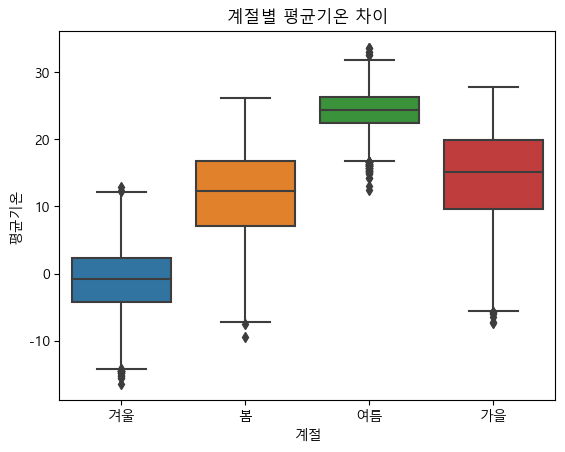

In [61]:
# '일시' 열을 datetime 형식으로 변환
train_df["일시"] = pd.to_datetime(train_df["일시"])

# '월' 정보를 추출하여 '계절' 변수 생성
train_df["월"] = train_df["일시"].dt.month
train_df["계절"] = train_df["월"].apply(
    lambda x: "봄"
    if 3 <= x <= 5
    else ("여름" if 6 <= x <= 8 else ("가을" if 9 <= x <= 11 else "겨울"))
)

# '계절' 변수와 '평균기온' 간의 관계 시각화 또는 분석 수행
# 예를 들어, boxplot을 이용하여 각 계절의 평균기온 분포를 확인할 수 있습니다.
sb.boxplot(x="계절", y="평균기온", data=train_df)
plt.title("계절별 평균기온 차이")
plt.show()

#### 일시 index로 설정

In [62]:
train_df.index = train_df["일시"]
train_df = train_df.drop(columns=["일시"])

## Stationary Check

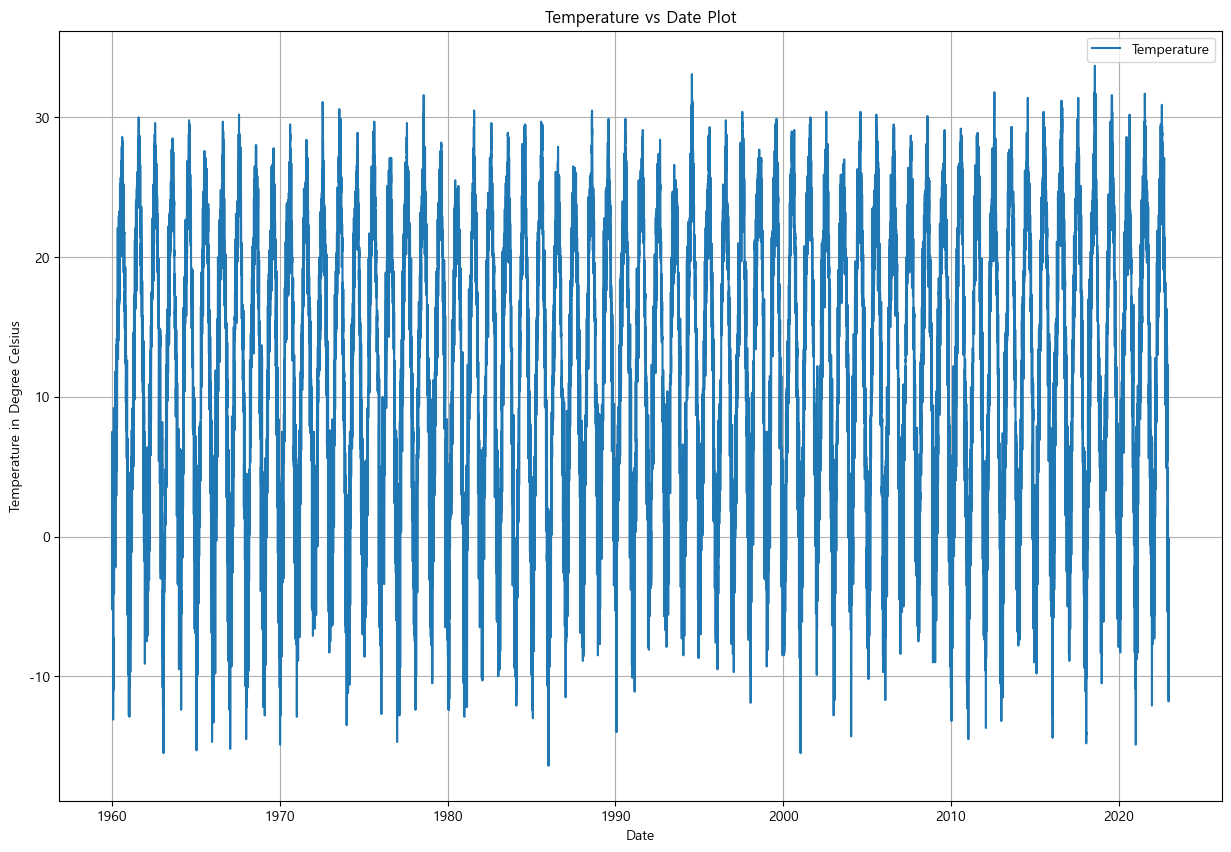

In [63]:
plt.figure(figsize=(15, 10))
plt.plot(train_df["평균기온"], label="Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature in Degree Celsius")
plt.title("Temperature vs Date Plot")
plt.grid()
plt.legend()
plt.show()

Seoul의 평균기온이 Seasonal pattern이 있는 것을 확인할 수 있다.

In [64]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming you have a time series data in your DataFrame, e.g., train_df['YourTimeSeriesColumn']
time_series = train_df["평균기온"]

# Perform Augmented Dickey-Fuller test:
result = adfuller(time_series.dropna())  # Drop NA values as ADF doesn't handle them

# Output the results:
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

ADF Statistic: -16.619186
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The time series is likely stationary.


##### The test result shows that the p-value is zero, indicating that we can reject the NULL hypothesis with more than a 95% confidence interval; hence, the time series is stationary

In [65]:
import sys
sys.path.append("C:/Users/yis82/OneDrive/Dacon/seoul-mean-temperature-prediction")
from toolbox import *

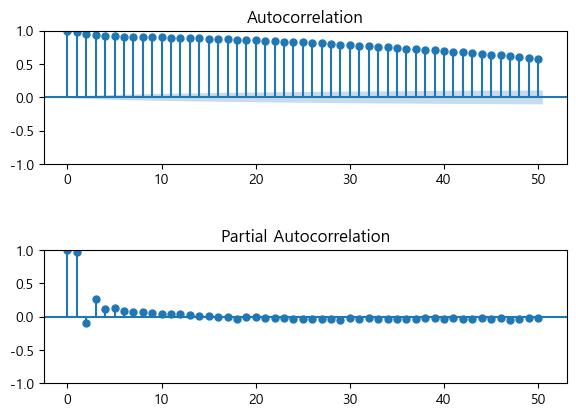

In [66]:
y = train_df["평균기온"]
lags = 50
ACF_PACF_Plot(y, lags)

high stationarity를 보여준다.

In [67]:
X = train_df.drop(["평균기온", "최저기온", "최고기온"], axis=1)
y = train_df["평균기온"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Length of X_train and y_train:", len(X_train))
print("Length of X_test and y_test:", len(X_test))

Length of X_train and y_train: 18408
Length of X_test and y_test: 4603


In [68]:
# Average forecasting
_, forecast_average = average_forecasting(y_train, y_test)
_, _, mse_average = cal_error_MSE(y_test, forecast_average)
rmse_average = np.sqrt(mse_average)
mae_average = mean_absolute_error(y_test, forecast_average)
print("MSE for Average forecasting:", np.round(mse_average, 2))
print("RMSE for Average forecasting:", np.round(rmse_average, 2))
print("MAE for Average forecasting:", np.round(mae_average, 2))


# Naive forecasting
_, forecast_Naive = Naive_forecasting(y_train, y_test)
_, _, mse_Naive = cal_error_MSE(y_test, forecast_Naive)
rmse_Naive = np.sqrt(mse_Naive)
mae_Naive = mean_absolute_error(y_test, forecast_Naive)
print("MSE for Naive forecasting:", np.round(mse_Naive, 2))
print("RMSE for Naive forecasting:", np.round(rmse_Naive, 2))
print("MAE for Naive forecasting:", np.round(mae_Naive, 2))

# Drift forecasting
_, forecast_Drift = drift_forecasting(y_train, y_test)
_, _, mse_average = cal_error_MSE(y_test, forecast_Drift)
rmse_average = np.sqrt(mse_average)
mae_average = mean_absolute_error(y_test, forecast_Drift)
print("MSE for Drift forecasting:", np.round(mse_average, 2))
print("RMSE for Drift forecasting:", np.round(rmse_average, 2))
print("MAE for Drift forecasting:", np.round(mae_average, 2))

# Simple Exponential Smoothing
L0 = y_train[0]
_, forecast_SES = ses(y_train, y_test, L0, alpha=0.9)
_, _, mse_SES = cal_error_MSE(y_test, forecast_SES)
rmse_SES = np.sqrt(mse_SES)
mae_SES = mean_absolute_error(y_test, forecast_SES)
print("MSE for SES forecasting:", np.round(mse_SES, 2))
print("RMSE for SES forecasting:", np.round(rmse_SES, 2))
print("MAE for SES forecasting:", np.round(mae_SES, 2))

MSE for Average forecasting: 117.24
RMSE for Average forecasting: 10.83
MAE for Average forecasting: 9.44
MSE for Naive forecasting: 118.56
RMSE for Naive forecasting: 10.89
MAE for Naive forecasting: 9.29
MSE for Drift forecasting: 130.33
RMSE for Drift forecasting: 11.42
MAE for Drift forecasting: 9.48
MSE for SES forecasting: 118.12
RMSE for SES forecasting: 10.87
MAE for SES forecasting: 9.29


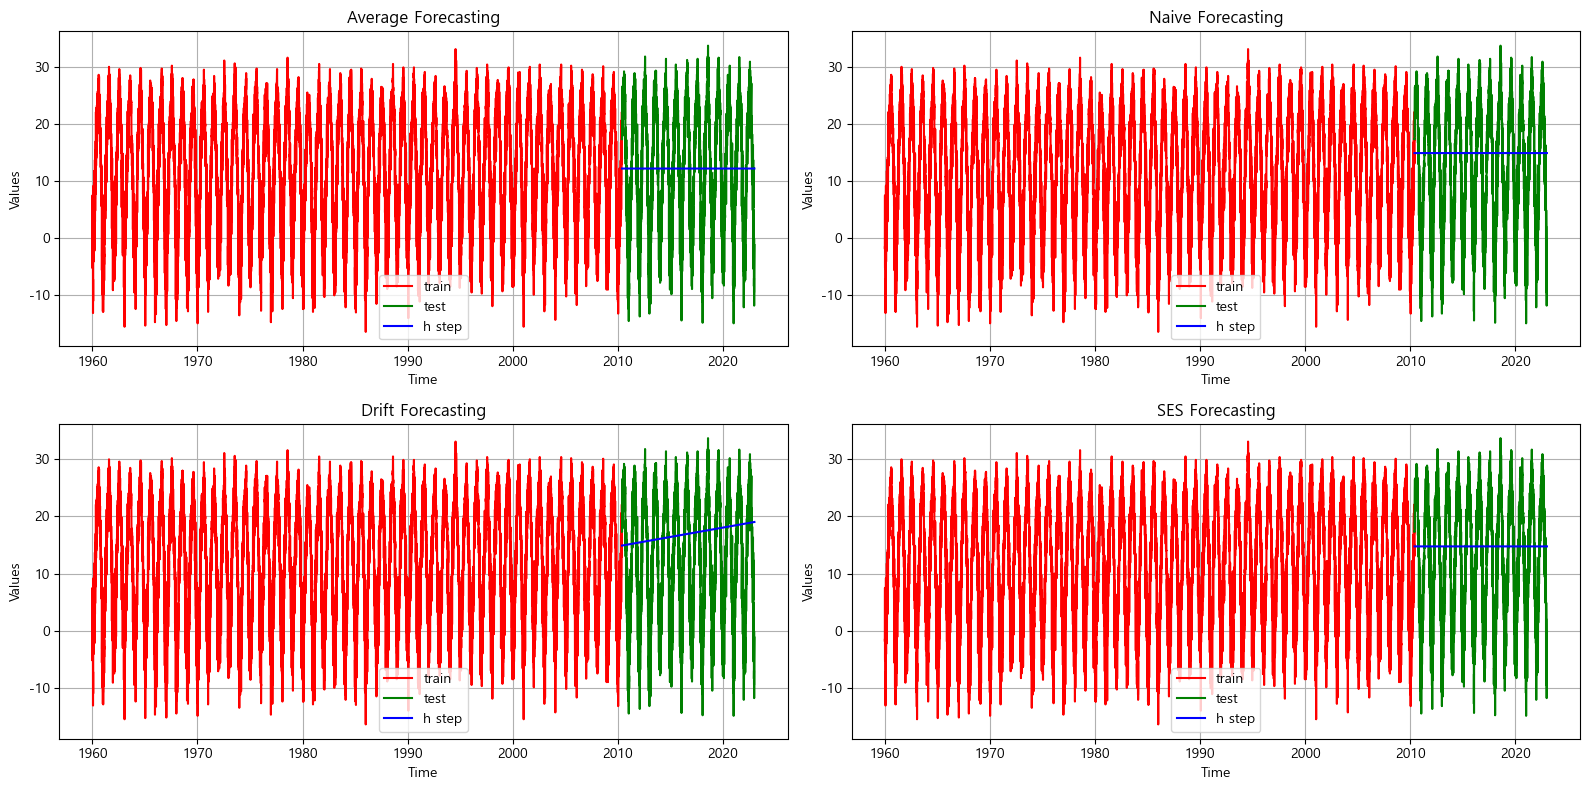

In [69]:
# subplots of the base models
fig = plt.figure(figsize=(16, 8))
axs = fig.subplots(2, 2)
plot_forecasting_models(
    y_train, y_test, forecast_average, "Average Forecasting", axs=axs[0][0]
)
plot_forecasting_models(
    y_train, y_test, forecast_Naive, "Naive Forecasting", axs=axs[0][1]
)
plot_forecasting_models(
    y_train, y_test, forecast_Drift, "Drift Forecasting", axs=axs[1][0]
)
plot_forecasting_models(y_train, y_test, forecast_SES, "SES Forecasting", axs=axs[1][1])
plt.tight_layout()
plt.show()

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


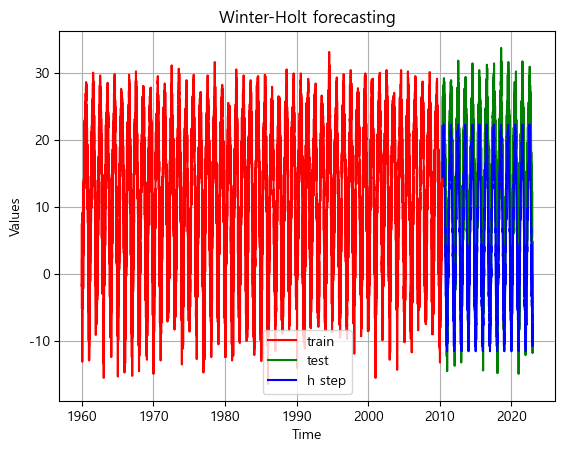

MSE for Winter-Holt method: 56.49
RMSE for Winter-Holt method: 7.52
MAE for Holt-Winter method: 6.62


In [70]:
modelES = ExponentialSmoothing(y_train, seasonal="add", seasonal_periods=365).fit()

forecastES = modelES.forecast(steps=len(y_test))

title = "Winter-Holt forecasting"
plot_forecasting_models(y_train, y_test, forecastES, title)

# Calculating MSE for Winter-Holt method
_, _, mse = cal_error_MSE(
    y_test, forecastES
)  # check my GitHub link to know more about this function.

rmse_winter = np.sqrt(mse)
mae_winter = mean_absolute_error(y_test, forecastES)
print("MSE for Winter-Holt method:", np.round(mse, 2))
print("RMSE for Winter-Holt method:", np.round(np.sqrt(mse), 2))
print("MAE for Holt-Winter method:", np.round(mae_winter, 2))

In [71]:
X_test

,일교차,평균습도,평균풍속,일조합,일사합,일조율,월,계절
일시,,,,,,,,
2010-05-26,7.7,60.8,2.8,6.4,21.65,44.1,5,봄
2010-05-27,12.5,53.0,2.5,11.4,26.66,78.6,5,봄
2010-05-28,5.9,66.4,1.9,0.0,12.68,0.0,5,봄
2010-05-29,8.7,63.1,1.7,2.7,15.34,18.6,5,봄
2010-05-30,8.4,59.4,2.2,6.1,20.45,42.1,5,봄
...,...,...,...,...,...,...,...,...
2022-12-27,10.6,69.8,1.8,8.8,10.25,91.7,12,겨울
2022-12-28,6.1,58.1,2.5,8.7,10.86,90.6,12,겨울
2022-12-29,9.9,56.3,1.7,9.0,10.88,93.8,12,겨울


#### 스케일링 진행을 위해 계절 변수를 숫자로 변경

In [72]:
X_train["계절"] = X_train["월"].apply(
    lambda x: 1 if 3 <= x <= 5 else (2 if 6 <= x <= 8 else (3 if 9 <= x <= 11 else 4))
)
X_test["계절"] = X_test["월"].apply(
    lambda x: 1 if 3 <= x <= 5 else (2 if 6 <= x <= 8 else (3 if 9 <= x <= 11 else 4))
)

1: 봄 (Spring)
2: 여름 (Summer)
3: 가을 (Autumn)
4: 겨울 (Winter)

In [112]:
X_train.describe()

,최고기온,최저기온,일교차,평균습도,평균풍속,일조합,일사합,일조율,월,계절
count,18408.000000,18408.000000,18408.000000,18408.000000,18408.00000,18408.000000,18408.000000,18408.000000,18408.000000,18408.000000
mean,16.823965,8.239543,8.584423,66.372697,2.37503,5.687109,9.793116,46.802879,6.494513,2.489352
std,10.658505,10.473382,2.898588,14.192930,0.97466,3.746818,6.154949,30.888145,3.452079,1.120635
min,-13.600000,-20.200000,1.000000,19.000000,0.10000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,7.600000,-0.400000,6.600000,56.300000,1.70000,2.100000,4.810000,17.500000,3.000000,1.000000
50%,18.600000,9.000000,8.600000,66.800000,2.20000,6.400000,7.960000,52.800000,6.000000,2.000000
75%,26.100000,17.500000,10.600000,77.000000,2.90000,8.800000,14.130000,75.800000,9.000000,3.000000
max,38.400000,28.800000,19.600000,99.000000,7.80000,13.600000,33.480000,95.500000,12.000000,4.000000


In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
condition_number = LA.cond(X_train_scaled)
print("condition_number:", condition_number)

condition_number: 9.748641000601467


In [76]:
X_svd = X_train.to_numpy()
H = np.matmul(X_svd.T, X_svd)

s, d, v = LA.svd(H)
print("SingularValues =", d)

SingularValues = [1.30142988e+08 1.76733071e+07 5.66793578e+05 2.14084754e+05
 1.10082723e+05 2.92116316e+04 1.93751565e+04 1.20501884e+04]


In [77]:
X_train_scaled = sm.add_constant(X_train_scaled)

cols = X_train.columns
cols = np.insert(cols, 0, "constant")
# Going forward with Backward Stepwise Regression to reduce features
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled = pd.concat(
    [pd.Series(1, index=X_test.index, name="constant"), X_test_scaled], axis=1
)
result = sm.OLS(y_train, X_train_scaled).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   평균기온   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     4289.
Date:                Mon, 25 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:16:47   Log-Likelihood:                -59552.
No. Observations:               18408   AIC:                         1.191e+05
Df Residuals:                   18399   BIC:                         1.192e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      12.1940      0.045    269.028      0.0

In [78]:
result = sm.OLS(y_train, X_train_scaled).fit()

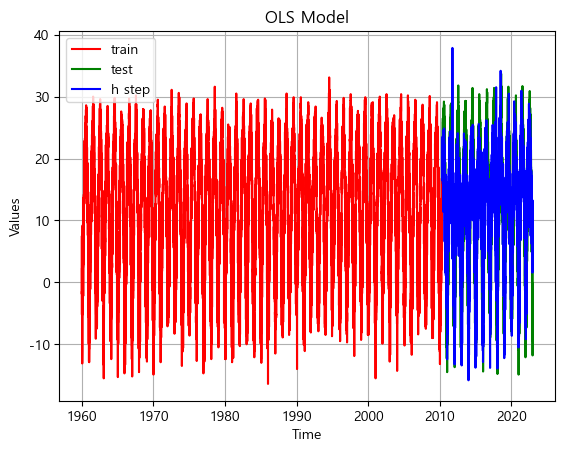

MSE for OLS model: 36.53
RMSE for OLS model: 6.04
MAE for OLS model: 5.0


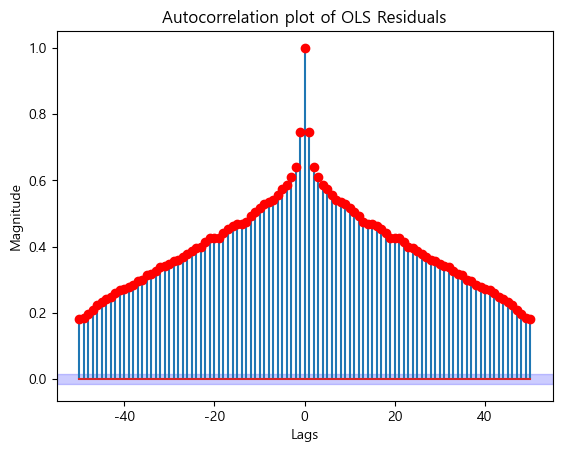

Q Value of OLS residuals: 156733.43
Mean of residuals for OLS: -2.157875983264485e-14
Variance of residuals for OLS: 37.79992470877951


In [79]:
pred_ols = result.predict(X_test_scaled)
plot_forecasting_models(y_train, y_test, pred_ols, "OLS Model")
mse_ols = mean_squared_error(y_test, pred_ols)
rmse_ols = np.sqrt(mse_ols)
mae_ols = mean_absolute_error(y_test, pred_ols)
print("MSE for OLS model:", np.round(mse_ols, 2))
print("RMSE for OLS model:", np.round(rmse_ols, 2))
print("MAE for OLS model:", np.round(mae_ols, 2))
ols_residuals = result.resid
q_ols = cal_Q_value(ols_residuals, "OLS Residuals", 50)
print("Q Value of OLS residuals:", np.round(q_ols, 2))
# 42426.55565814915
print("Mean of residuals for OLS:", np.mean(ols_residuals))
print("Variance of residuals for OLS:", np.var(ols_residuals))

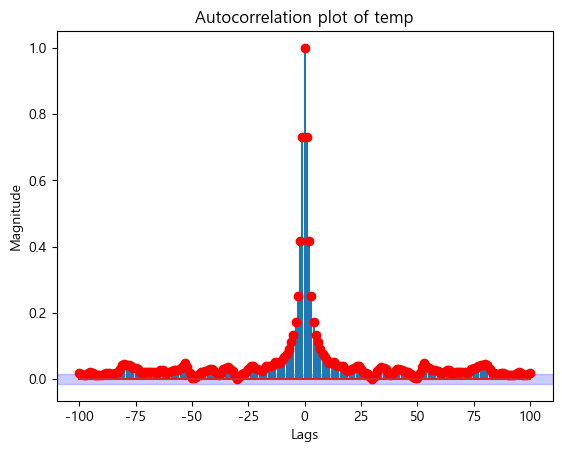

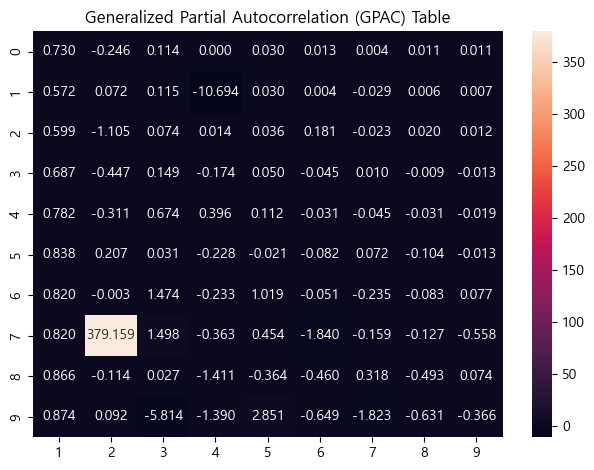

          1           2         3          4         5         6         7  \
0  0.729548   -0.245854  0.114052   0.000322  0.030236  0.013369  0.004324   
1  0.571916    0.072129  0.114738 -10.694173  0.030093  0.003592 -0.029017   
2  0.599166   -1.104546  0.074300   0.014290  0.036106  0.181400 -0.022972   
3  0.687002   -0.447045  0.149171  -0.173693  0.050452 -0.044964  0.010051   
4  0.782396   -0.310586  0.673709   0.396293  0.111955 -0.030892 -0.044804   
5  0.837517    0.207463  0.031291  -0.228279 -0.021348 -0.081710  0.072028   
6  0.820066   -0.003239  1.474491  -0.232891  1.019018 -0.050753 -0.235268   
7  0.819983  379.158653  1.498086  -0.363233  0.453729 -1.840370 -0.158794   
8  0.866387   -0.113933  0.027019  -1.410547 -0.363571 -0.459919  0.318146   
9  0.873829    0.091589 -5.813732  -1.390467  2.850570 -0.648566 -1.823135   

          8         9  
0  0.010783  0.011099  
1  0.006334  0.007268  
2  0.020074  0.011521  
3 -0.008530 -0.013411  
4 -0.031047 -0.019118

In [80]:
y_diff = differencing(y_train, 1, 365)  # s = 365 for seasonal differencing
y_diff = np.array(removeNA(y_diff))
y_diff = y_diff.astype(float)

ry = cal_autocorr(y_diff, 100, "temp")

cal_gpac(ry, 10, 10)

# all the functions used above can be found on my GitHub link

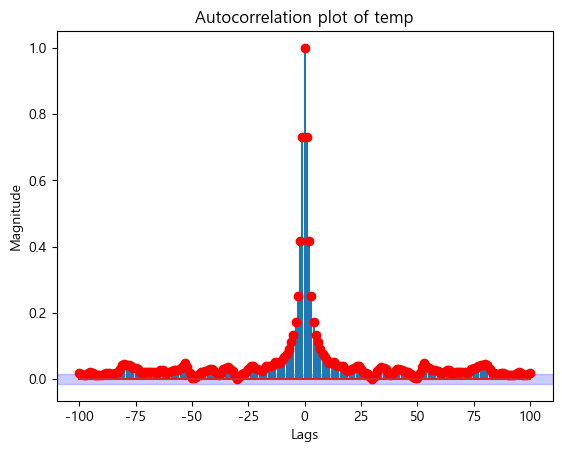

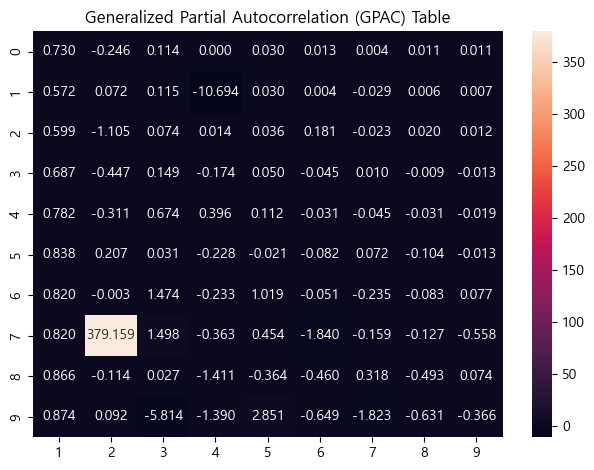

          1           2         3          4         5         6         7  \
0  0.729548   -0.245854  0.114052   0.000322  0.030236  0.013369  0.004324   
1  0.571916    0.072129  0.114738 -10.694173  0.030093  0.003592 -0.029017   
2  0.599166   -1.104546  0.074300   0.014290  0.036106  0.181400 -0.022972   
3  0.687002   -0.447045  0.149171  -0.173693  0.050452 -0.044964  0.010051   
4  0.782396   -0.310586  0.673709   0.396293  0.111955 -0.030892 -0.044804   
5  0.837517    0.207463  0.031291  -0.228279 -0.021348 -0.081710  0.072028   
6  0.820066   -0.003239  1.474491  -0.232891  1.019018 -0.050753 -0.235268   
7  0.819983  379.158653  1.498086  -0.363233  0.453729 -1.840370 -0.158794   
8  0.866387   -0.113933  0.027019  -1.410547 -0.363571 -0.459919  0.318146   
9  0.873829    0.091589 -5.813732  -1.390467  2.850570 -0.648566 -1.823135   

          8         9  
0  0.010783  0.011099  
1  0.006334  0.007268  
2  0.020074  0.011521  
3 -0.008530 -0.013411  
4 -0.031047 -0.019118

In [81]:
ry = cal_autocorr(y_diff, 100, "temp")

cal_gpac(ry, 10, 10)
# from the GPAC, the most probable order is ARMA(1, 0) and (1, 4)
na = 7
nb = 0

theta_hat, variance_hat, covariance_hat, sse_array = LM(y_diff, na, nb)
theta_hat = theta_hat.ravel()

print("Estimated parameters")
print(theta_hat)
print()
print("Estimated parameters with 95% confidence interval")
for i in range(na):
    print(
        f"{theta_hat[i]-(2*np.sqrt(covariance_hat[i][i]))} < a{i+1} < {theta_hat[i]+(2*np.sqrt(covariance_hat[i][i]))}"
    )
print()
j = 0
for i in range(na, na + nb):
    print(
        f"{theta_hat[i] - (2 * np.sqrt(covariance_hat[i][i]))} < b{j + 1} < {theta_hat[i] + (2 * np.sqrt(covariance_hat[i][i]))}"
    )
    j += 1

print("\nEstimated covariance matrix")
print(covariance_hat)
print()

print("Estimated variance")
print(variance_hat)
print()

print("Estimated standard deviation")
print(np.sqrt(variance_hat))
print()

Roots of the denominator are: [ 0.75159481  0.38683475  0.38683475 -0.06195636 -0.06195636 -0.23239149
 -0.23239149]


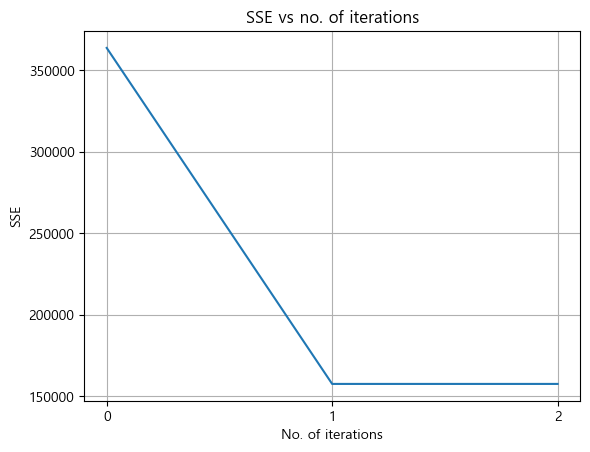

In [82]:
se_array = np.array(sse_array)
den, num = num_den(theta_hat, na, nb)
if num[1] != 0:
    print("Roots of the numerator are:", np.roots(num).real)

if den[1] != 0:
    print("Roots of the denominator are:", np.roots(den).real)

# Since, there is only one root of the process, there is no
# zero pole cancellation

x = np.arange(len(sse_array))
plt.plot(x, sse_array)
plt.xticks(np.arange(x[0], x[-1] + 1, 1))
plt.xlabel("No. of iterations")
plt.ylabel("SSE")
plt.grid()
plt.title("SSE vs no. of iterations")
plt.show()

Lags 25


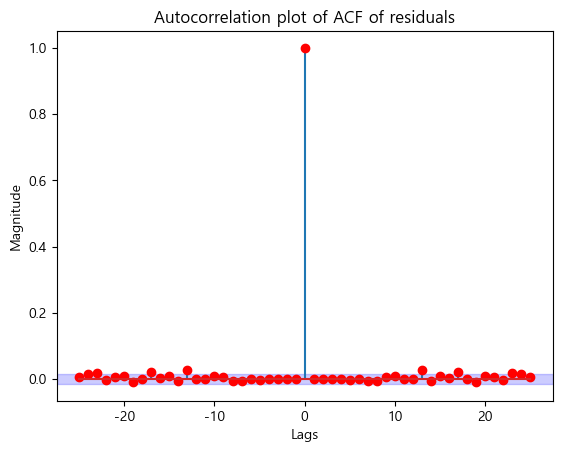

Chi critical: 34.805305734705065
Q Value: 38.61786856826187
Alfa value for 99% accuracy: 0.01
The residual is NOT white 


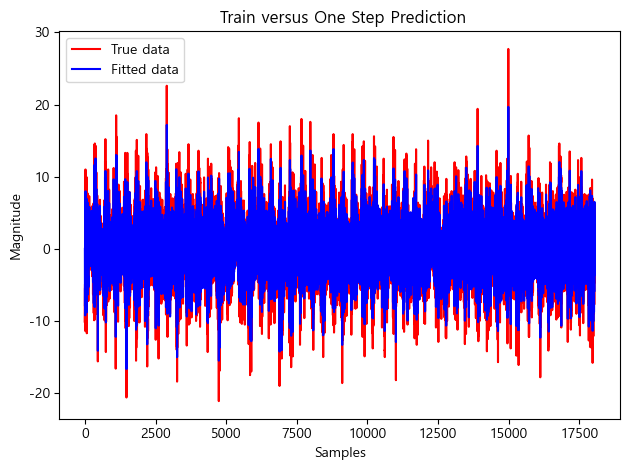

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18043
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -45151.785
Date:                Mon, 25 Dec 2023   AIC                          90321.570
Time:                        00:17:04   BIC                          90391.775
Sample:                             0   HQIC                         90344.654
                              - 18043                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.077     -0.015      0.988      -0.153       0.151
ar.L1          0.9370      0.007    141.364      0.000       0.924       0.950
ar.L2         -0.3530      0.009    -37.445      0.0

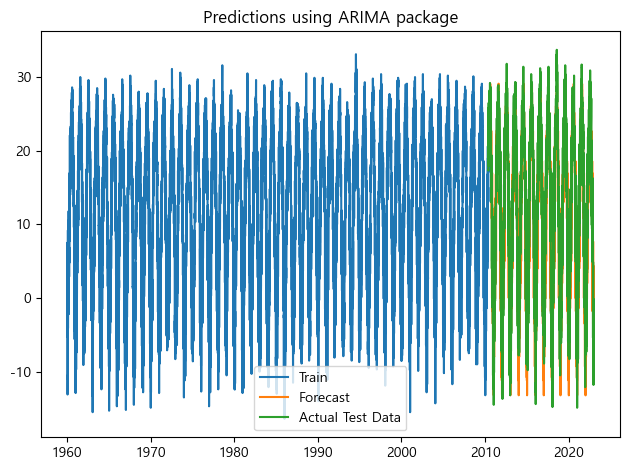

MSE of ARIMA using package with order (7, 0): 22.47925825670632
MSE for ARIMA: 22.48
RMSE for ARIMA: 4.74
MAE for ARIMA: 3.59


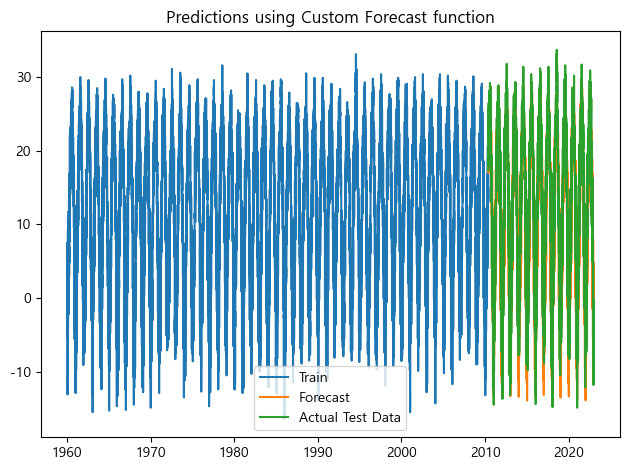

Variance of residual error: 8.74
Variance of forecast error: 22.14
MSE of ARIMA using custom function with order (7, 0): 23.480451579078473


In [83]:
model_ARIMA, model_hat = prediction(y_diff, na, nb)
print(model_ARIMA.summary())

prediction1 = model_ARIMA.forecast(len(y_test))
prediction1 = pd.Series(prediction1, index=y_test.index)
y_arima_package_hat = reverse_transform_and_plot(
    prediction1, y_train, y_test, "ARIMA package"
)
mse_arima_package = mean_squared_error(y_test, y_arima_package_hat)
print("MSE of ARIMA using package with order (7, 0):", mse_arima_package)
rmse_arima_package = np.sqrt(mse_arima_package)
mae_arima_package = mean_absolute_error(y_test, y_arima_package_hat)
print("MSE for ARIMA:", np.round(mse_arima_package, 2))
print("RMSE for ARIMA:", np.round(rmse_arima_package, 2))
print("MAE for ARIMA:", np.round(mae_arima_package, 2))


y_hat_test = forecast(y_diff, len(y_diff), len(y_test))
y_hat_test = pd.Series(y_hat_test)
y_hat_test.index = y_test.index

y_arima_custom_hat = reverse_transform_and_plot(
    y_hat_test, y_train, y_test, "Custom Forecast function"
)
mse_custom = mean_squared_error(y_test, y_arima_custom_hat)
print("Variance of residual error:", np.round(variance_hat[0][0], 2))
print("Variance of forecast error:", np.round(np.var(y_test - y_arima_custom_hat), 2))

print("MSE of ARIMA using custom function with order (7, 0):", mse_custom)

In [84]:
from tensorflow.keras import Sequential

# from keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense, LSTM, Dropout  # ,CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

In [85]:
train_df["계절"] = train_df["월"].apply(
    lambda x: 1 if 3 <= x <= 5 else (2 if 6 <= x <= 8 else (3 if 9 <= x <= 11 else 4))
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 365, 64)           19200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                23000     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 42251 (165.04 KB)
Trainable params: 42251 (165.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
777/777 [==============================] - 173s 218ms/step - loss: 0.0784 - val_loss: 0.0466
Epoch 2/10
777/777 [========================

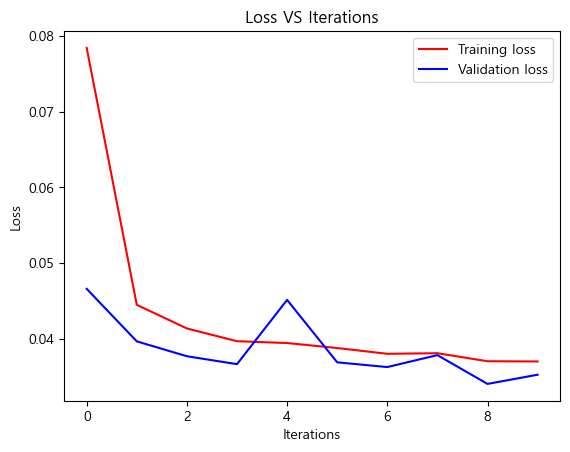

144/144 [==============================] - 23s 148ms/step


C:\Users\yis82\AppData\Local\Temp\ipykernel_20484\2024556101.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


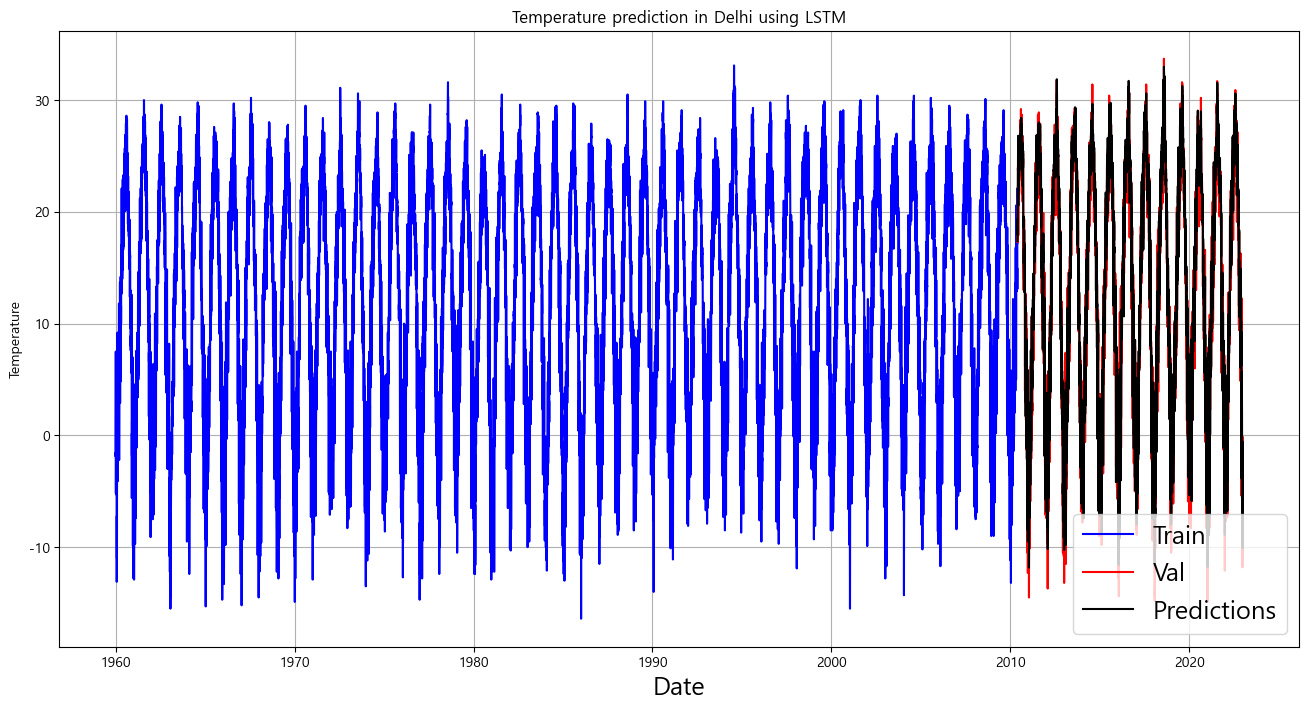

MSE for LSTM model: 4.18
RMSE for LSTM model: 2.05
MAE for LSTM model: 1.53


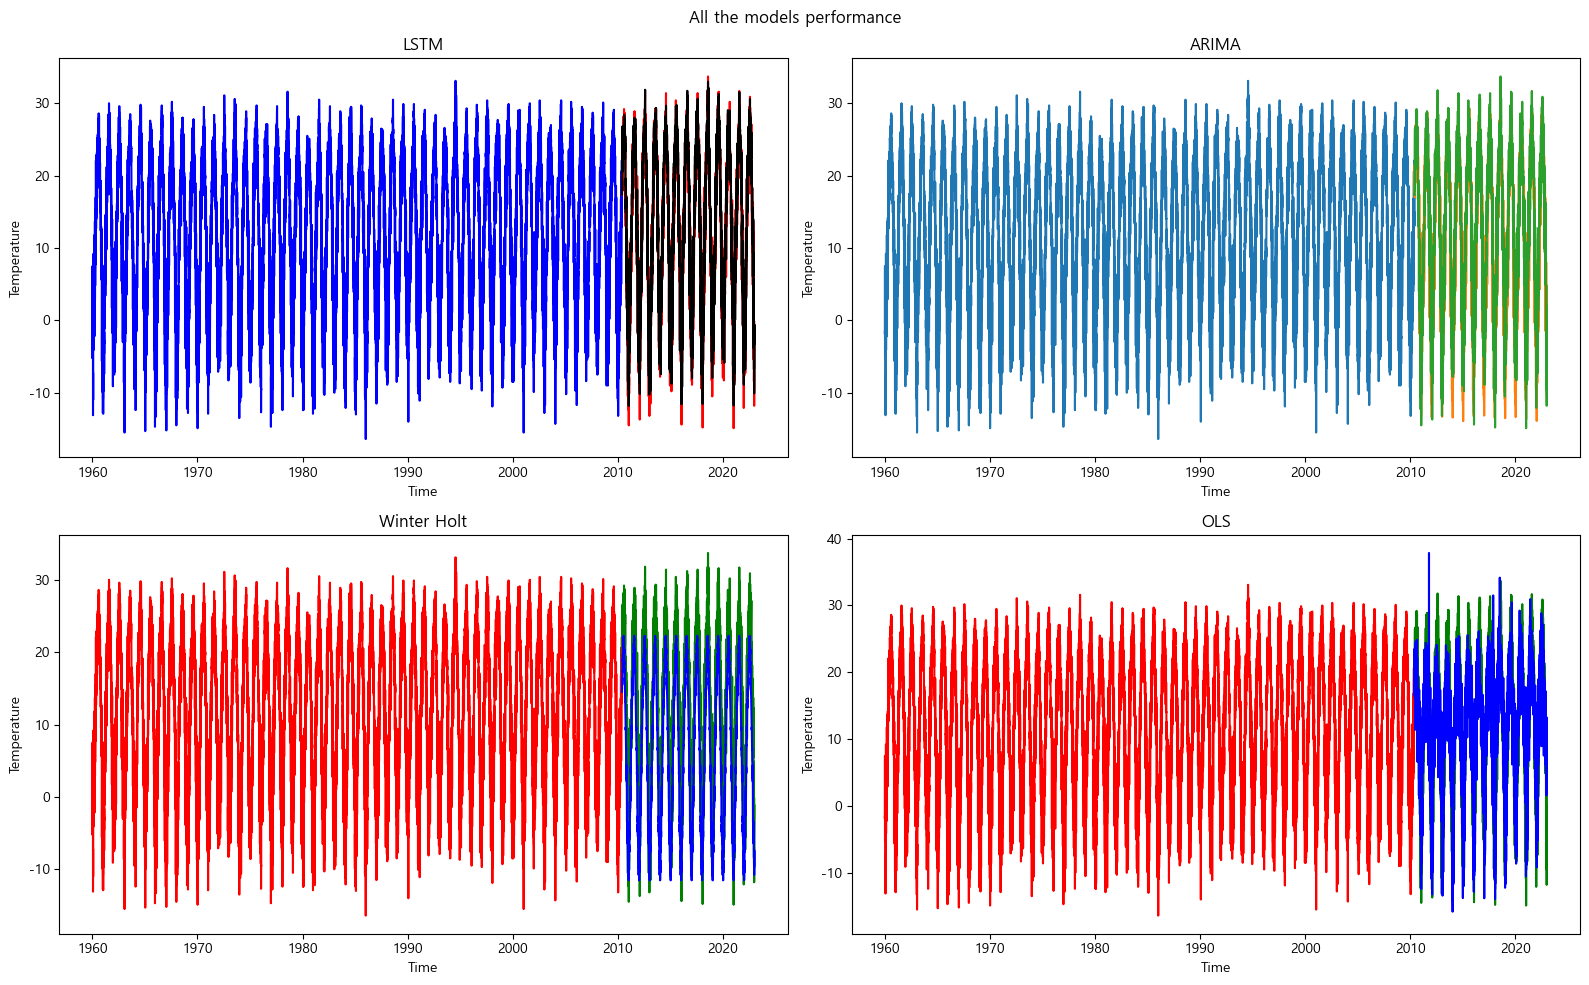

In [88]:
df2 = train_df.copy()
col_to_move = "평균기온"
last_col = df2.pop(col_to_move)
df2.insert(len(df2.columns), col_to_move, last_col)

scaler = StandardScaler()
scaler = scaler.fit(df2)
scaled_data = scaler.transform(df2)
train_size = int(len(df2) * 0.8)
train_data = scaled_data[:train_size, :]
time_step = 365
train_X, train_y = [], []
n_past = len(y) - train_size
for i in range(n_past, len(train_data)):
    train_X.append(train_data[i - time_step : i, 0 : train_data.shape[1] - 1])
    train_y.append(train_data[i, train_data.shape[1] - 1])

train_X = np.array(train_X)
train_y = np.array(train_y)

model = Sequential()
model.add(
    LSTM(
        64,
        activation="relu",
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True,
    )
)
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(
    train_X, train_y, batch_size=16, validation_split=0.1, epochs=10, verbose=1
)
plt.figure()
plt.plot(history.history["loss"], "r", label="Training loss")
plt.plot(history.history["val_loss"], "b", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss VS Iterations")
plt.legend()
plt.show()
dataset = df2.values
test_data = scaled_data[train_size - 365 :, :]
x_test = []
y_test = dataset[train_size:, -1]

for i in range(365, len(test_data)):
    x_test.append(test_data[i - 365 : i, 0 : train_data.shape[1] - 1])

joblib.dump(model, "LSTM_model.pkl")

model = joblib.load("LSTM_model.pkl")
x_test = np.array(x_test)
predictions = model.predict(x_test)
forecast_copies = np.repeat(predictions, train_X.shape[2] + 1, axis=-1)
predictions = scaler.inverse_transform(forecast_copies)[:, -1]

train = df2.iloc[:train_size]
valid = df2.iloc[train_size:]
valid["Predictions"] = predictions

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.set_title("Temperature prediction in Delhi using LSTM")
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Temperature")
ax.plot(train["평균기온"], "blue")
ax.plot(valid["평균기온"], "red")
ax.plot(valid["Predictions"], "black")
ax.legend(["Train", "Val", "Predictions"], loc="lower right", fontsize=18)
ax.grid()
plt.show()
mse_lstm = mean_squared_error(valid["평균기온"], valid["Predictions"])
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(valid["평균기온"], valid["Predictions"])
print("MSE for LSTM model:", np.round(mse_lstm, 2))
print("RMSE for LSTM model:", np.round(rmse_lstm, 2))
print("MAE for LSTM model:", np.round(mae_lstm, 2))


X = train_df.drop(["평균기온",], axis=1)
y = train_df["평균기온"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(train["평균기온"], "blue")
axs[0, 0].plot(valid["평균기온"], "red")
axs[0, 0].plot(valid["Predictions"], "black")
axs[0, 0].set_title("LSTM")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Temperature")

axs[0, 1].plot(y_train.index, y_train.values, label="Train")
axs[0, 1].plot(y_arima_custom_hat.index, y_arima_custom_hat.values, label="Forecast")
axs[0, 1].plot(y_test.index, y_test.values, label="Actual Test Data")
axs[0, 1].set_title("ARIMA")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Temperature")

axs[1, 0].plot(y_train.index, y_train, color="r", label="train")
axs[1, 0].plot(y_test.index, y_test, color="g", label="test")
axs[1, 0].plot(y_test.index, forecastES, color="b", label="h step")
axs[1, 0].set_title("Winter Holt")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Temperature")

axs[1, 1].plot(y_train.index, y_train, color="r", label="train")
axs[1, 1].plot(y_test.index, y_test, color="g", label="test")
axs[1, 1].plot(y_test.index, pred_ols, color="b", label="h step")
axs[1, 1].set_title("OLS")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Temperature")
fig.suptitle("All the models performance")

plt.tight_layout()
plt.show()

In [ ]:
from prophet import Prophet
import numpy as np

# Fit the model
m = Prophet(changepoint_prior_scale=0.05)
m.add_seasonality(name="", period=365.25, fourier_order=5)
model = m.fit(train_df)

# Make predictions
future = m.make_future_dataframe(
    periods=0
)  # Use 0 if you only want to fit on training data
forecast = m.predict(future)

# Calculate residuals
residuals = train_df["y"] - forecast["yhat"][: len(train_df)]

# Approximate log-likelihood
n = len(train_df)
sigma2 = np.var(residuals)
log_likelihood = (
    -n / 2 * np.log(2 * np.pi)
    - n / 2 * np.log(sigma2)
    - 1 / (2 * sigma2) * np.sum(residuals**2)
)

# Count number of parameters
# For simplicity, count the number of changepoints, seasonality parameters, and base parameters
num_changepoints = len(model.params["delta"][0])
num_seasonality_parameters = 5  # Fourier order for quarterly
num_base_parameters = 1  # Just the growth rate for now
p = num_changepoints + num_seasonality_parameters + num_base_parameters

# Calculate AIC
AIC = 2 * p - 2 * log_likelihood

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
future = m.make_future_dataframe(periods=358, freq="d")
forecast = m.predict(future)

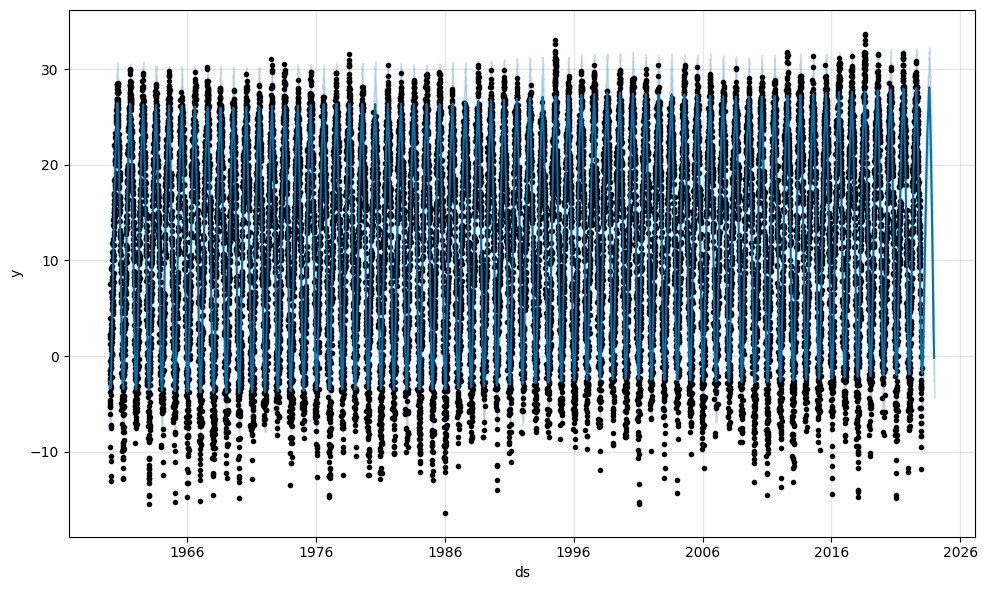

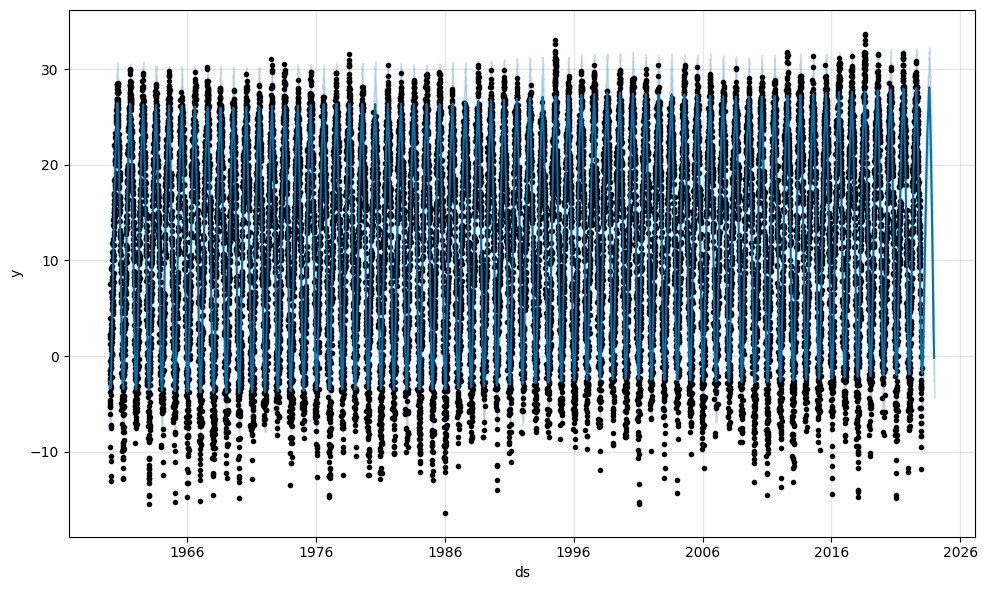

In [ ]:
m.plot(forecast)

In [ ]:
predict = list(forecast[forecast["ds"].apply(lambda x: x.year) == 2023]["yhat"])

In [ ]:
submission = pd.read_csv("./open/sample_submission.csv")
submission["평균기온"] = predict
submission

,일시,평균기온
0,2023-01-01,-1.083313
1,2023-01-02,-1.156044
2,2023-01-03,-1.248000
3,2023-01-04,-1.295499
4,2023-01-05,-1.323980
...,...,...
353,2023-12-20,0.452361
354,2023-12-21,0.305392
355,2023-12-22,0.131745
356,2023-12-23,0.027570


In [ ]:
submission.to_csv("./3__20231217.csv", index=False)

In [ ]:
param_grid = {
    "changepoint_prior_scale": [0.001, 0.005, 0.01, 0.03],
    "seasonality_prior_scale": [0.1, 0.5, 1.0, 3.0],
    "seasonality_mode": ["additive", "multiplicative"],
}

all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]
maes = []

# initial: 학습할 구간, horizon: 예측할 구간, period: cutoff 간격
# 3년 주기로 15년치를 학습하고 이후 1년을 예측
for params in all_params:
    m = prophet.Prophet(**params, yearly_seasonality=True).fit(
        train_df
    )  # Fit model with given params
    df_cv = cross_validation(
        m,
        initial="5475 days",
        period="1095 days",
        horizon="365 days",
        parallel="processes",
    )
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p["mae"].values[0])


tuning_results = pd.DataFrame(all_params)
tuning_results["mae"] = maes
print(tuning_results)

NameError: name 'prophet' is not defined

In [ ]:
# 최적의 hyper parameter 확인   
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [ ]:
m = Prophet(**best_params, yearly_seasonality=True)
m.fit(train_df)
future = m.make_future_dataframe(periods=358, freq="d")
forecast = m.predict(future)

23:45:18 - cmdstanpy - INFO - Chain [1] start processing
23:45:20 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:94: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


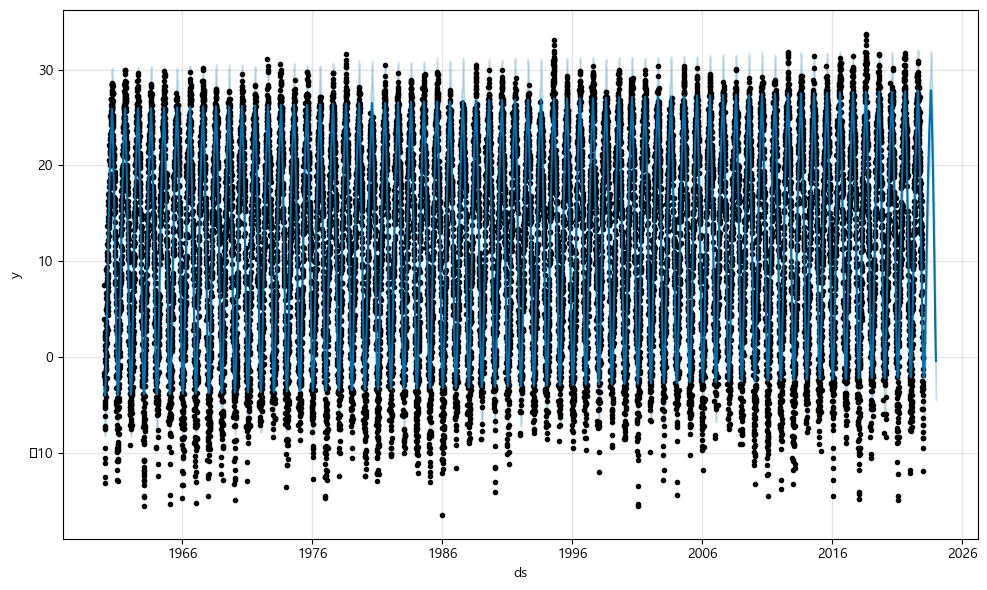

C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


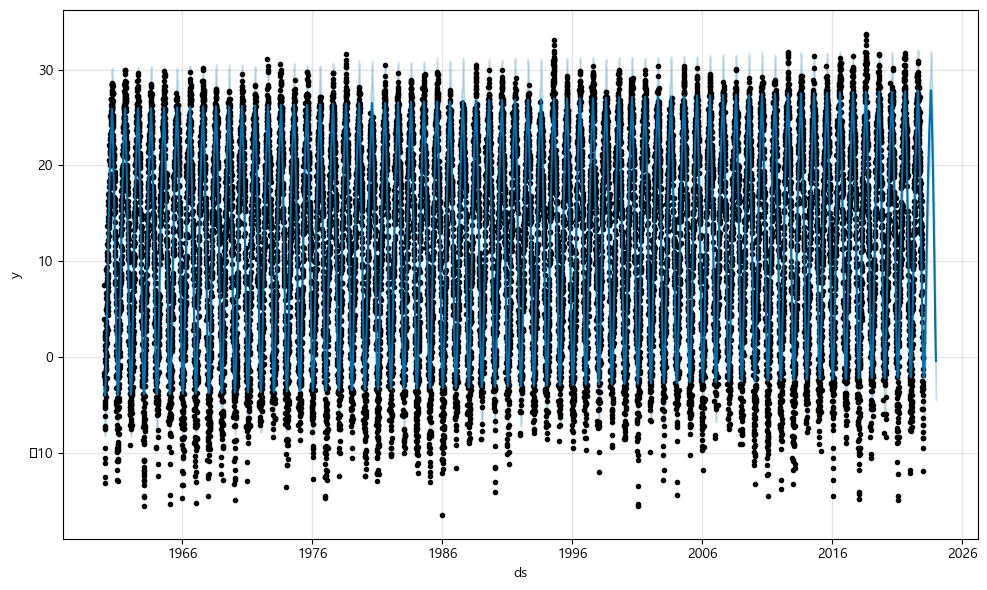

In [ ]:
m.plot(forecast)

In [ ]:
predict = list(forecast[forecast["ds"].apply(lambda x: x.year) == 2023]["yhat"])

In [ ]:
submission = pd.read_csv("./open/sample_submission.csv")
submission["평균기온"] = predict
submission

,일시,평균기온
0,2023-01-01,-1.305874
1,2023-01-02,-1.407339
2,2023-01-03,-1.523243
3,2023-01-04,-1.588105
4,2023-01-05,-1.626453
...,...,...
353,2023-12-20,0.109126
354,2023-12-21,0.002057
355,2023-12-22,-0.129993
356,2023-12-23,-0.195058


In [ ]:
submission.to_csv("./2__20231217.csv", index=False)